In [1]:
import cv2
import numpy as np
import numpy.random as npr
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import skimage as sk
import skimage.io as skio
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from torch.distributions.categorical import Categorical
import math
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from preprocess import mean, std, preprocess_input_function
from settings import train_dir, test_dir, train_push_dir, train_batch_size, test_batch_size, train_push_batch_size
from settings import base_architecture, img_size, prototype_shape, num_classes, prototype_activation_function, add_on_layers_type
from receptive_field import compute_rf_prototype
import cv2
from preference_model import construct_PrefNet, paired_cross_entropy_loss, PrefNet
from tqdm import tqdm
from settings import joint_optimizer_lrs, joint_lr_step_size
import skimage as sk
import skimage.io as skio
import train_and_test as tnt
from torch.utils.data import Subset
%matplotlib inline

In [2]:
ppnet = torch.load(r'../saved_models/vgg19/004/100_7push0.7344.pth')
ppnet = torch.nn.DataParallel(ppnet)
pf_model = construct_PrefNet("resnet18")
pf_model.load_state_dict(torch.load("./human_comparisons/pref_model_009_65+35_ep50_adam_0.0001"))

<All keys matched successfully>

In [3]:
normalize = transforms.Normalize(mean=mean, std=std)

train_dataset = datasets.ImageFolder(
        train_push_dir,
        transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
        normalize,
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=80, shuffle=False,
    num_workers=2, pin_memory=False)

test_dataset = datasets.ImageFolder(
        test_dir,
        transforms.Compose([
            transforms.Resize(size=(img_size, img_size)),
            transforms.ToTensor(),
            normalize,
        ]))
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=False,
    num_workers=2, pin_memory=False)



In [4]:
root_dirs = [
    "../A3C_results/PPnet_prototypes/"
]
dirs = []
for i in range(0, len(root_dirs)):
    for j in range(1000):
        dirs.append(root_dirs[i] + str(j) + '/')
k = 1

In [5]:
csv_name = "./human_comparisons/rating_s=5_k=1_500.csv"
if os.path.exists(csv_name):
    comp_df = pd.read_csv(csv_name)
    
else:
    comp_df = pd.DataFrame({"imgid": [], "rating": []})

In [6]:
print(len(comp_df))

500


In [11]:

#indices = np.random.choice(6000, 100)
#shuffled_dataset = Subset(train_dataset, indices)
indices = range(0, 100)
batch_dataset = Subset(train_dataset, indices)
dataloader = torch.utils.data.DataLoader(
    batch_dataset, batch_size=100, shuffle=False,
    num_workers=2, pin_memory=False)
data_iter = iter(dataloader)
batch_x, labels = next(data_iter)


In [12]:
ppnet.eval()
n_prototypes = ppnet.module.num_prototypes
prototype_shape = ppnet.module.prototype_shape
max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]
protoL_rf_info = ppnet.module.proto_layer_rf_info

batch_x = batch_x.cuda()
protoL_input_torch, proto_dist_torch = ppnet.module.push_forward(batch_x)
proto_dist = proto_dist_torch.detach().cpu().numpy()
heatmaps = []
original_imgs = []
rescaled_patterns = []
for i in range(batch_x.shape[0]):
    class_identity = labels[i]
    for k in range(5):
        act_pattern = np.log((proto_dist[i][class_identity * 5 + k] + 1)/(proto_dist[i][class_identity * 5 + k] + ppnet.module.epsilon))
        upsampled_act_pattern = cv2.resize(act_pattern, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
        rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
        rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)
        heatmap = cv2.applyColorMap(np.uint8(255*rescaled_act_pattern), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        heatmap = heatmap[..., ::-1]
        original_img = batch_x[i].cpu().numpy()
        original_img = np.transpose(original_img, (1, 2, 0))
        overlayed_original_img = 0.5 * original_img + 1.0 * heatmap
        overlayed_original_img = overlayed_original_img - np.amin(overlayed_original_img)
        overlayed_original_img = overlayed_original_img / np.amax(overlayed_original_img)
        heatmaps.append(overlayed_original_img)
        original_img = original_img - np.amin(original_img)
        original_img = original_img / np.amax(original_img)
        original_imgs.append(original_img)
        rescaled_patterns.append(rescaled_act_pattern)

print(len(heatmaps))
print(rescaled_patterns[0].shape)

500
(224, 224, 3)


In [15]:
print(rescaled_patterns[0].shape)

(224, 224)


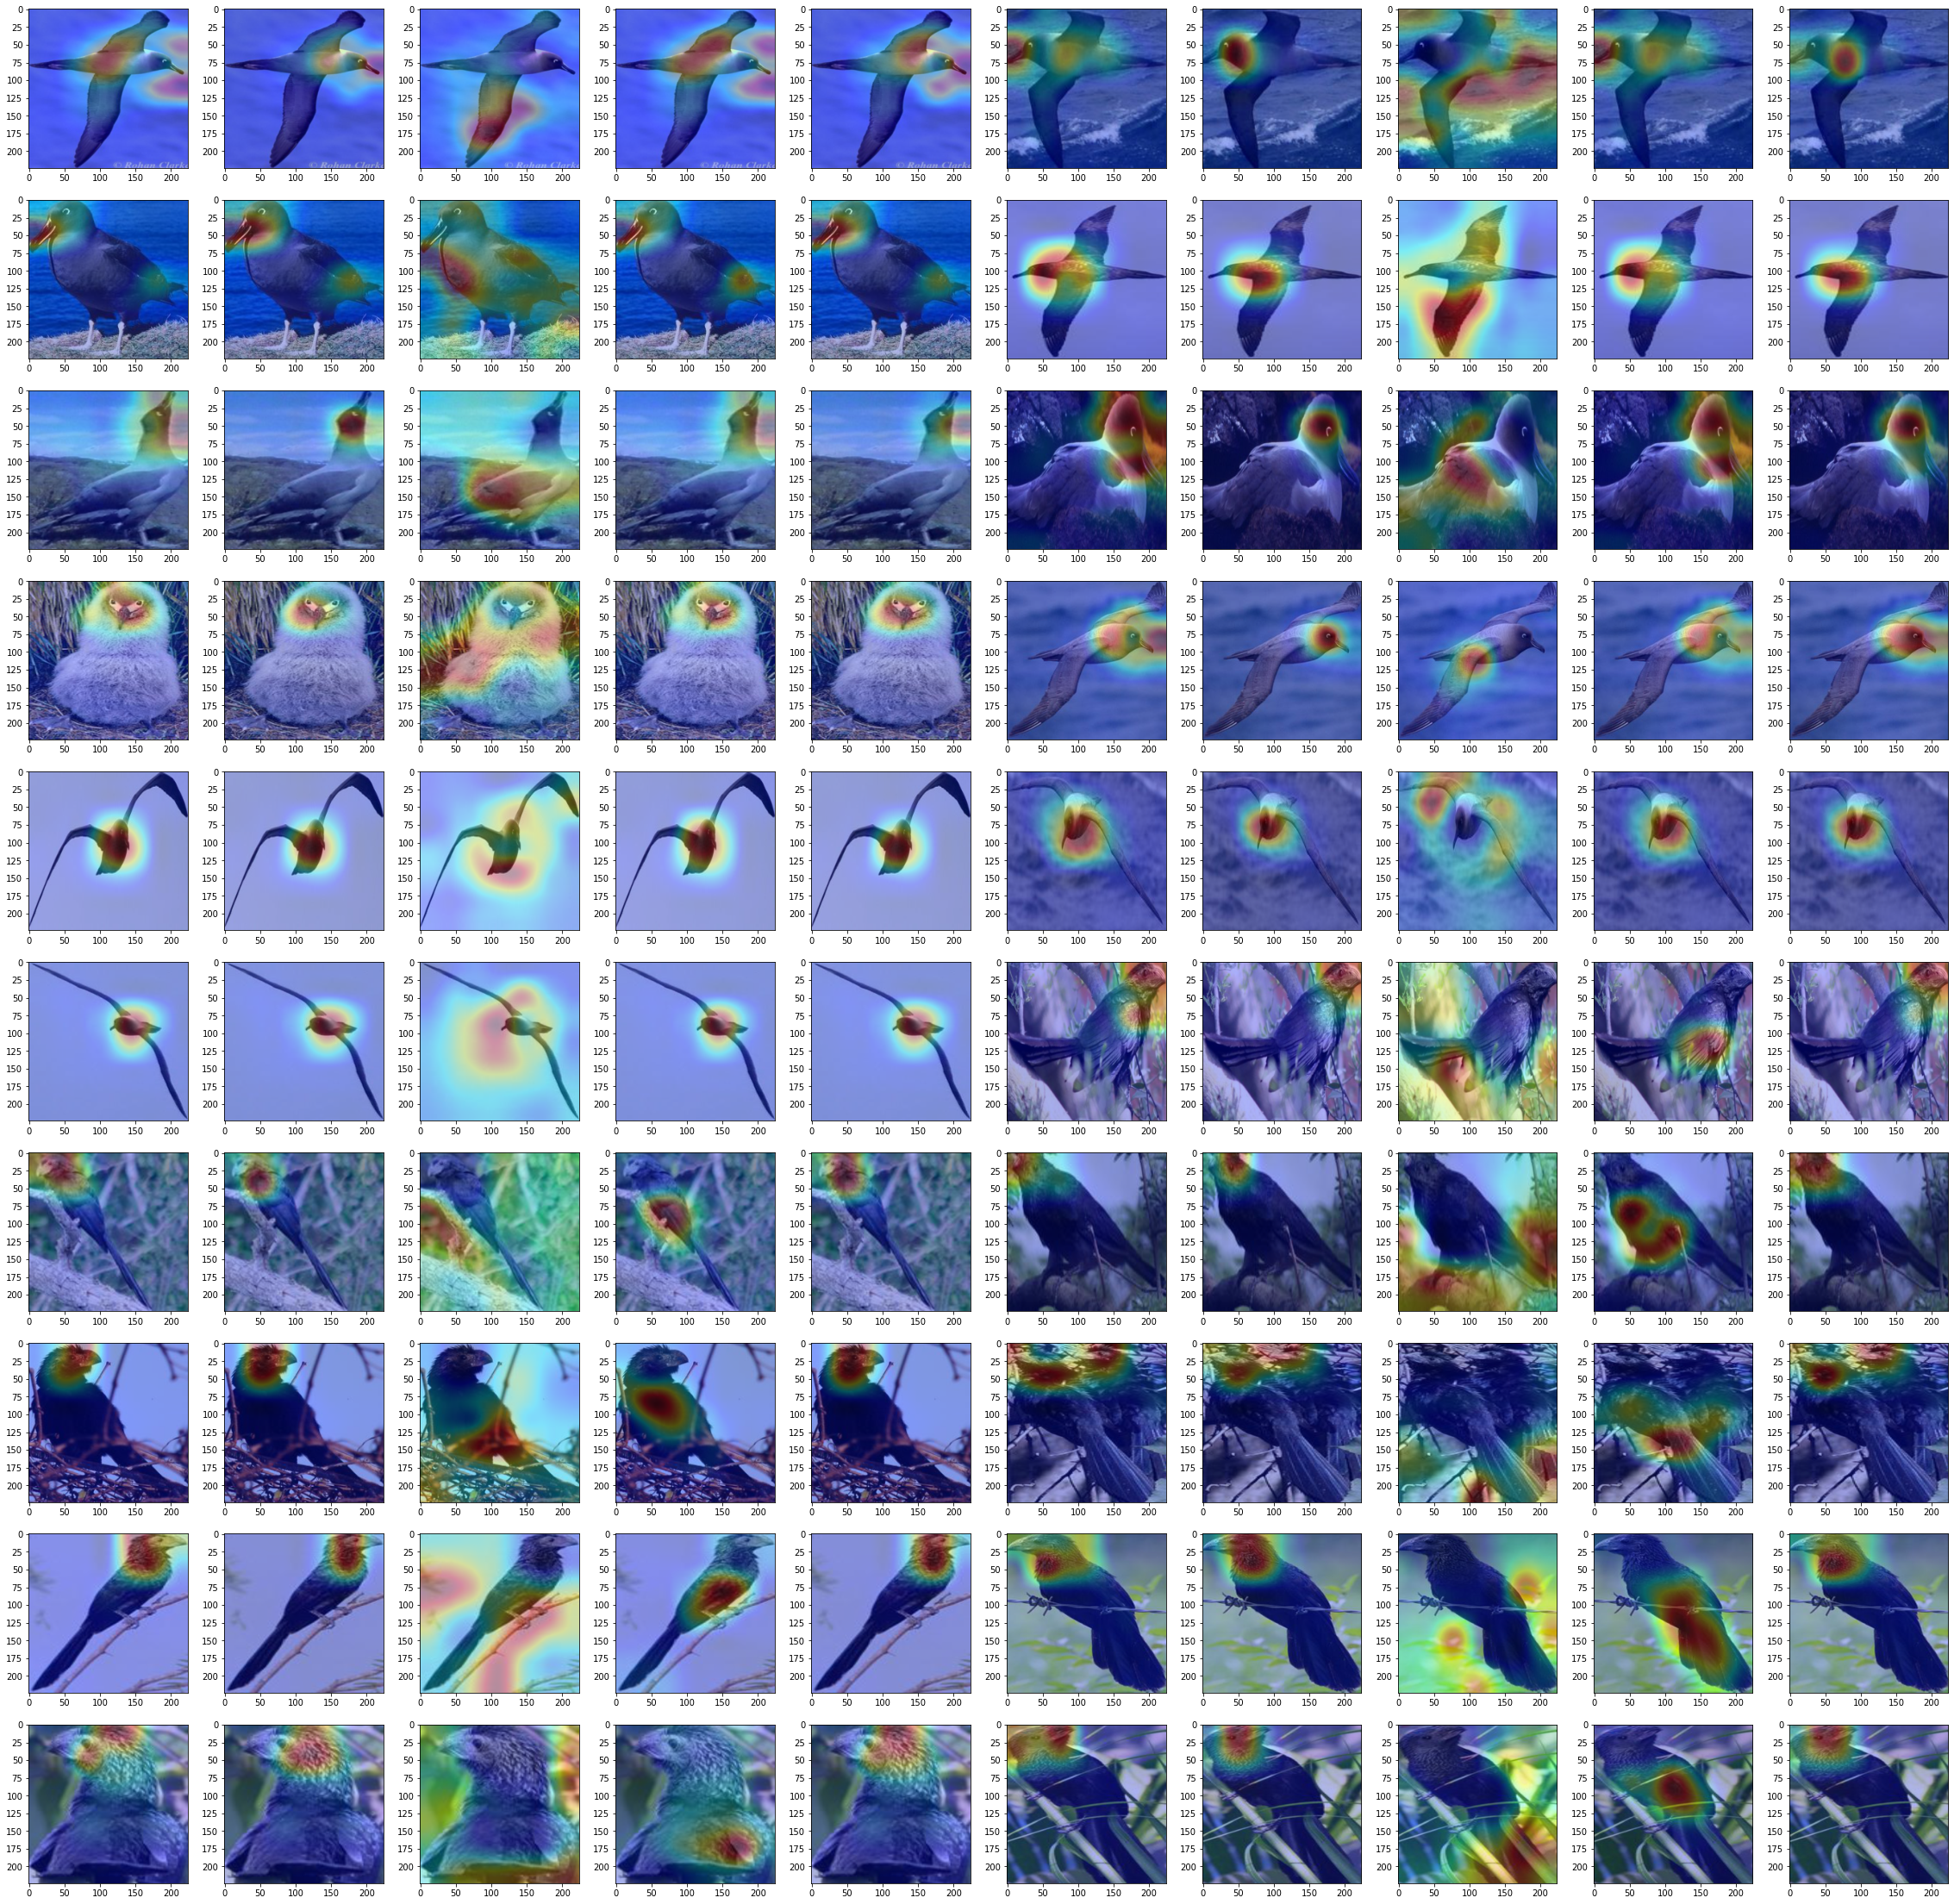

In [55]:
f, axarr = plt.subplots(10, 10, figsize=(40,40))
for i in range(10):
    for j in range(10):
        axarr[i][j].imshow(heatmaps[i*10+j])

In [13]:
'''
Rubrics for rating:
5 - on body, and is indeed somehow unique; almost same as how human would pick prototypes
4 - on body, but may not be the best from human perspective (e.g. multiple separate parts within the same prototype)
3 - 
2 - more background than body, but has some useful information
1 - no overlap with the body, completely background (e.g. completely off single patch)
'''
ids = []
for i in indices:
    for j in range(5):
        ids.append(str(i)+"_"+str(j))
ratings = [3, 4, 5, 3, 4, 5, 5, 2, 5, 5,
           5, 5, 4, 5, 5, 5, 5, 5, 5, 5,
           4, 5, 5, 4, 3, 5, 5, 5, 5, 5,
           5, 5, 3, 5, 5, 4, 5, 5, 4, 5,
           5, 5, 4, 5, 5, 5, 5, 4, 5, 5,
           5, 5, 3, 5, 5, 5, 5, 2, 5, 5,
           5, 5, 1, 5, 5, 5, 5, 1, 5, 5,
           5, 5, 4, 5, 5, 5, 5, 2, 4, 5,
           5, 5, 1, 5, 5, 5, 5, 1, 5, 5,
           5, 5, 1, 5, 5, 4, 5, 1, 5, 5]

In [16]:
for i in range(len(heatmaps)):
    #plt.imsave('./human_comparisons/feedback_images/k=1/original_imgs/' + ids[i] + '.png', original_imgs[i])
    np.save('./human_comparisons/feedback_images/k=1/patterns/' + ids[i] + '.npy', rescaled_patterns[i])

In [57]:
#for i in range(len(ids)):
#    comp_df = comp_df.append(pd.DataFrame({"imgid": [ids[i]], "rating": [ratings[i]]}))

In [58]:
#print(len(comp_df))
#comp_df.to_csv(csv_name)

500
